<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W1D3/tutorials/W1D3-ModelFitting/W1D3_Tutorial6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week 1, Day 3, Tutorial 6
# Model Selection: Bias-variance trade-off


#Tutorial Objectives

This is Tutorial 6 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of linear models by  generalizing to multiple linear regression (Tutorial 4). We then move on to polynomial regression (Tutorial 5). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 6) and two common methods for model selection, AIC and Cross Validation (Tutorial 7). 


In this tutorial, we will learn about the bias-variance tradeoff and see it in action using polynomial regression models.

Tutorial objectives:

* Understand difference between test and train data
* Compare train and test error for models of varying complexity
* Understand how bias-variance tradeoff relates to what model we choose

Video available at https://youtube.com/watch?v=c6EjIrhkUpc


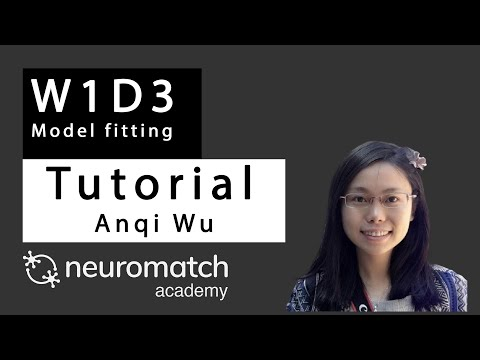

In [ ]:
#@title Video Bias Variance Tradeoff
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="c6EjIrhkUpc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


# Setup

In [ ]:
#@title  Imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [ ]:
#@title Helper functions
def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vecto"r of measurements of shape (n_samples)
  
  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  return np.linalg.inv(x.T @ x) @ x.T @ y

def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression
  
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    max_order (scalar): The order of the polynomial we want to fit

  Returns:
    numpy array: The design matrix containing x raised to different powers
  """

  # Broadcast to shape (n x 1) if shape (n, ) so this function generalizes to multiple inputs
  if x.ndim == 1:
    x = x[:,None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0],1)) 

  # Loop through rest of degrees and stack columns
  for degree in range(1, order+1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix


def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.
  
  Args:
    x (ndarray): An array of shape (samples, ) that contains the input values 
    y (ndarray): An array of shape (samples, ) that contains the output values
    max_order (scalar): The order of the polynomial we want to fit

  Returns:
    numpy array: (input_features, max_order+1) Each column contains the fitted 
    weights for that order of polynomial regression
  """

  # Create a dictionary with polynomial order as keys, and np array of theta 
  # (weights) as the values
  theta_hat = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order+1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hat[order] = this_theta

  return theta_hat


# Train vs test data

 The data used for the fitting procedure for a given model is the **training data**. In tutorial 5, we computed MSE on the training data of our polynomial regression models and compared training MSE across models. An additional important type of data is **test data**. This is held-out data that is not used (in any way) during the fitting procedure. When fitting models, we often want to consider both the train error (the quality of prediction on the training data) and the test error (the quality of prediction on the test data) as we will see in the next section.


# Bias-variance tradeoff

Finding a good model can be difficult. One of the most important concepts to keep in mind when modeling is the **bias-variance tradeoff**. 

**Bias** is the difference between the prediction of the model and the corresponding true output variables you are trying to predict. Models with high bias will not fit the training data well since the predictions are quite different from the true data. These high bias models are overly simplified - they do not have enough parameters and complexity to accurately capture the patterns in the data and are thus **underfitting**.


**Variance** refers to the variability of model predictions for a given input. Essentially, do the model predictions change a lot with changes in the exact training data used? Models with high variance are highly dependent on the exact training data used - they will not generalize well to test data. These high variance models are **overfitting** to the data.

In essence:

* High bias, low variance models have high train and test error.
* Low bias, high variance models have low train error, high test error
*Low bias, low variance models have low train and test error


As we can see from this list, we ideally want low bias and low variance models! These goals can be in conflict though - models with enough complexity to have low bias also tend to overfit and depend on the training data more. We need to decide on the correct tradeoff.

In this section, we will see the bias-variance tradeoff in action with polynomial regression models of different orders.


### Data generation & model fitting

We first generate some noisy data using a similar process as in Tutorial 5. 

We will generate our training data the exact same way as in Tutorial 5. However, now we will also generate test data. We want to see how our model generalizes beyond the range of values see in the training phase. To accomplish this, we will generate x from a wider range of values ([-3, 3]). We then plot the train and test data together.

We will then fit polynomial regression models of orders 0-5 just as we did in Tutorial 5. 

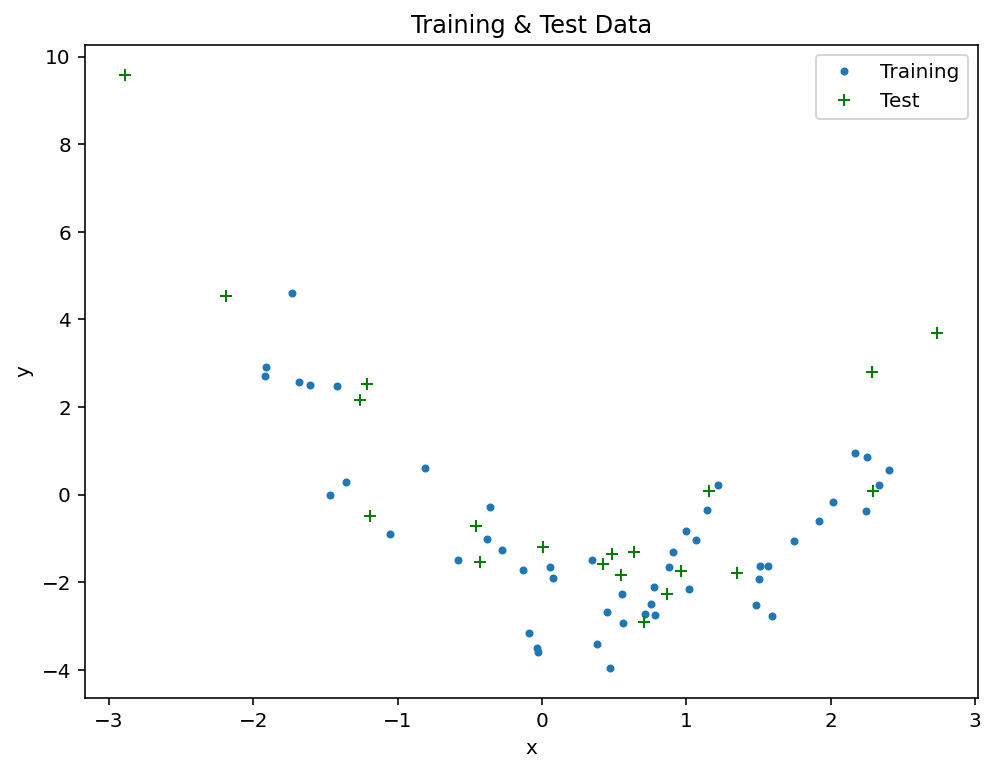

In [ ]:
### Generate training data
np.random.seed(0)
n_samples = 50
x_train = np.random.uniform(-2, 2.5, n_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y_train =  x_train**2 - x_train - 2 + noise

### Generate testing data
n_samples = 20
x_test = np.random.uniform(-3, 3, n_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y_test =  x_test**2 - x_test - 2 + noise

## Plot both train and test data
fig, ax = plt.subplots()
plt.title('Training & Test Data')
plt.plot(x_train, y_train, '.', label='Training')
plt.plot(x_test, y_test, 'g+', label='Test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

## Run this cell to get estimated parameters

In [ ]:
# Let's fit some models!
max_order = 5
theta_hat = solve_poly_reg(x_train, y_train, max_order)

#### Exercise: Compute and compare train vs test error

We will use MSE as our error metric again. Compute MSE on training data ($x_{train},y_{train}$) and test data ($x_{test}, y_{test}$ for each polynomial regression model (orders 0-5). Hint: we computed MSE on train data in Tutorial 5 so port those concepts/code here

*Please think about after completing exercise before reading the following text! Do you think the order 0 model has high or low bias? High or low variance? How about the order 5 model?*

In [ ]:
def compute_mse(x_train,x_test,y_train,y_test,theta_hat,max_order):

  """Compute MSE on training data and test data.
    
  Args:
    x_train(ndarray):An array of shape (samples, ) that contains the training set input values.
    x_test(ndarray): An array of shape (samples,) that contains the test set values.
    y_train(ndarray): An array of shape (samples, ) that contains the output values.
    y_test(ndarray): An array of shape (samples, ) that contains the output testing set.
    theta_hat(numpy array): (input_features, max_order+1) Each column contains the fitted 
    weights for that order of polynomial regression
    max_order (scalar): The order of the polynomial we want to fit

  Returns:
    mse_train: MSE error on training data for each order
    mse_test: MSE error on test data for each order
  """

  #######################################################
  ## TODO for students: calculate mse error for both sets
  ## Hint: look back at tutorial 5 where we calculated MSE
  #######################################################
  #uncomment below and fill in with your code

  mse_train = np.zeros((max_order+1))
  #for order in range(0, max_order+1):
    #X_design_train = YOUR CODE HERE
    #y_hat = YOUR CODE HERE
    #residuals = YOUR CODE HERE
    #mse_train[order] = YOUR CODE HERE

  mse_test = np.zeros((max_order+1))
  #for order in range(0, max_order+1):
    #X_design_test =YOUR CODE HERE
    #y_hat = YOUR CODE HERE
    #residuals = YOUR CODE HERE
    #mse_test[order] = YOUR CODE HERE

  # comment this out when you've filled in the function
  raise NotImplementedError("Student excercise: calculate mse for train and test set")
  return mse_train, mse_test

# Uncomment once exercise complete
#mse_train, mse_test = compute_mse(x_train,x_test,y_train,y_test,theta_hat,max_order)

#width = .35
#plt.figure()
#plt.bar(np.arange(max_order+1) - width/2, mse_train, width, label="train MSE")
#plt.bar(np.arange(max_order+1) + width/2, mse_test , width, label="test MSE")
#plt.legend()
#plt.xlabel('polynomial order')
#plt.ylabel('MSE')
#plt.title('comparing polynomial fits');

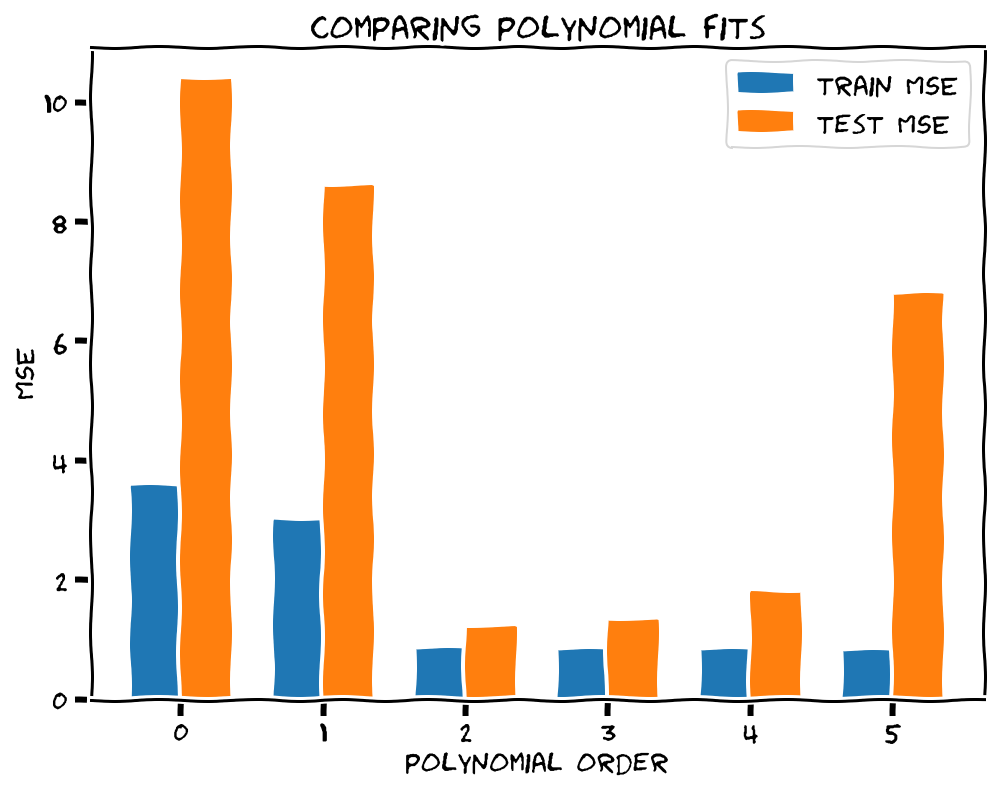

In [ ]:
# to_remove solution

def compute_mse(x_train,x_test,y_train,y_test,theta_hat,max_order):

  """Compute MSE on training data and test data.
    
  Args:
    x_train(ndarray):An array of shape (samples, ) that contains the training set input values.
    x_test(ndarray): An array of shape (samples,) that contains the test set values.
    y_train(ndarray): An array of shape (samples, ) that contains the output values.
    y_test(ndarray): An array of shape (samples, ) that contains the output testing set.
    theta_hat(numpy array): (input_features, max_order+1) Each column contains the fitted 
    weights for that order of polynomial regression
    max_order (scalar): The order of the polynomial we want to fit

  Returns:
    mse_train: MSE error on training data for each order
    mse_test: MSE error on test data for each order
  """

  mse_train = np.zeros((max_order+1))
  for order in range(0, max_order+1):
    X_design_train = make_design_matrix(x_train, order)
    y_hat = np.dot(X_design_train, theta_hat[order])
    residuals = y_train - y_hat
    mse_train[order] = np.mean(residuals ** 2)

  mse_test = np.zeros((max_order+1))
  for order in range(0, max_order+1):
    X_design_test = make_design_matrix(x_test, order)
    y_hat = np.dot(X_design_test, theta_hat[order])
    residuals = y_test - y_hat
    mse_test[order] = np.mean(residuals ** 2)

  return mse_train, mse_test

mse_train, mse_test = compute_mse(x_train,x_test,y_train,y_test,theta_hat,max_order)

with plt.xkcd():
  width = .35
  plt.figure()
  plt.bar(np.arange(max_order+1) - width/2, mse_train, width, label="train MSE")
  plt.bar(np.arange(max_order+1) + width/2, mse_test , width, label="test MSE")
  plt.legend()
  plt.xlabel('polynomial order')
  plt.ylabel('MSE')
  plt.title('comparing polynomial fits');


As we can see from the plot above, more complex models (higher order polynomials) have lower MSE for training data. The overly simplified models (orders 0 and 1) have high MSE on the training data. As we add complexity to the model, we go from high bias to low bias. 

The MSE on test data follows a different pattern. The best test MSE is for an order 2 model. Both simple models and more complex models have higher test MSE. 

So to recap:

Order 0 model: High bias, low variance

Order 5 model: Low bias, high variance

Order 2 model: Just right, low bias, low variance


# Summary

Training data is the data used for fitting, test data is held-out data.

We need to strike the right balance between bias and variance. 

Too complex models have low bias and high variance. Too simple models have high bias and low variance. We want to find a model with optimal model complexity that has both low bias and low variance